In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../coal-price-data/demand-forecasting-kernels-only/train.csv", index_col=0)
data = data.reset_index()
data.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [3]:
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns")

The dataset has 913000 rows and 4 columns


In [4]:
data.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

In [6]:
data = data.loc[data["store"] <= 2]
print(f"The dataset now has {data.shape[0]} rows and {data.shape[1]} columns")

The dataset now has 182600 rows and 4 columns
The dataset now has 182600 rows and 4 columns


In [7]:
data[["store", "item"]] = data[["store", "item"]].astype(str)

In [8]:
count_duplicate_rows = len(data)-len(data.drop_duplicates())
print(f"There are {count_duplicate_rows} duplicate rows")

There are 0 duplicate rows


In [9]:
data["store_item"] = data["store"] + "_" + data["item"]

In [10]:
data["date"] = pd.to_datetime(data["date"])

In [11]:
item_sales_per_date = data.groupby(["date","store_item"])["sales"].aggregate("sum")
item_sales_per_date = item_sales_per_date.reset_index()
item_sales_per_date.columns = ["date","store_item","sales"]
item_sales_per_date = item_sales_per_date.sort_values("date", ascending=True)
item_sales_per_date.head()

date store_item  sales
0  2013-01-01        1_1     13
72 2013-01-01        2_3     19
71 2013-01-01       2_29     50
70 2013-01-01       2_28     45
69 2013-01-01       2_27     17

In [12]:
item_sales_per_date.tail()

date store_item  sales
182527 2017-12-31       1_34     32
182526 2017-12-31       1_33     61
182524 2017-12-31       1_31     48
182535 2017-12-31       1_41     25
182599 2017-12-31        2_9     75

<Axes: xlabel='date'>

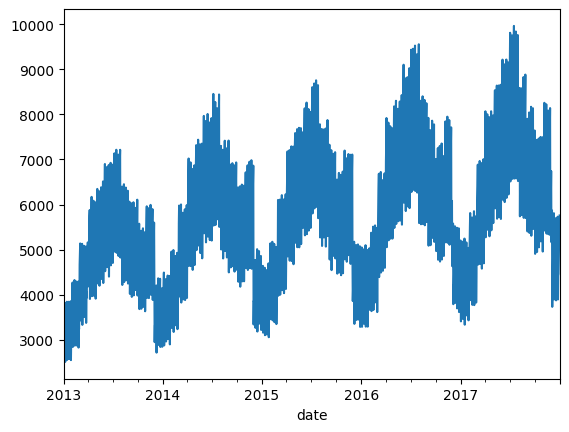

In [13]:
total_sales_per_date = item_sales_per_date.groupby(["date"])["sales"].aggregate("sum")
total_sales_per_date.plot()

In [15]:
import itertools

multiindex = list(zip(item_sales_per_date["date"], item_sales_per_date["store_item"]))
multiindex = pd.MultiIndex.from_tuples(multiindex, names=('index_1', 'index_2'))

dataset = item_sales_per_date.copy()
dataset.index = multiindex


idx_dates = list(pd.date_range(min(item_sales_per_date["date"]), max(item_sales_per_date["date"])))
idx_ids = list(dataset["store_item"].unique())
idx = list(itertools.product(idx_dates, idx_ids))
dataset = dataset.reindex(idx)
dataset = dataset.reset_index()
dataset.head()

index_1 index_2       date store_item  sales
0 2013-01-01     1_1 2013-01-01        1_1     13
1 2013-01-01     2_3 2013-01-01        2_3     19
2 2013-01-01    2_29 2013-01-01       2_29     50
3 2013-01-01    2_28 2013-01-01       2_28     45
4 2013-01-01    2_27 2013-01-01       2_27     17

In [16]:
dataset["date"] = dataset["date"].fillna(dataset["index_1"])
dataset["store_item"] = dataset["store_item"].fillna(dataset["index_2"])
dataset["sales"] = dataset["sales"].fillna(0)
dataset = dataset.drop(columns=["index_1", "index_2"])
dataset = dataset.set_index("date")
dataset.index.name = "date"
dataset.head()

store_item  sales
date                        
2013-01-01        1_1     13
2013-01-01        2_3     19
2013-01-01       2_29     50
2013-01-01       2_28     45
2013-01-01       2_27     17

In [18]:
# Rename columns to match the Nixtlaverse's expectations
# The 'store_item' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'sales' becomes 'y' representing the target variable we want to forecast
# Y_df = dataset.query('unique_id.str.startswith("6_46")').copy()
Y_df = dataset.copy()
Y_df = Y_df.reset_index()
Y_df = Y_df.rename(columns={
    'store_item': 'unique_id', 
    'date': 'ds', 
    'sales': 'y'
})
Y_df['y'] = Y_df['y'].astype(int)
# Convert the 'ds' column to datetime format to ensure proper handling of date-related operations in subsequent steps
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.tail()

Y_df['unique_id'] = Y_df['unique_id'].astype(str)
Y_df

ds unique_id   y
0      2013-01-01       1_1  13
1      2013-01-01       2_3  19
2      2013-01-01      2_29  50
3      2013-01-01      2_28  45
4      2013-01-01      2_27  17
...           ...       ...  ..
182595 2017-12-31      1_36  71
182596 2017-12-31      1_35  55
182597 2017-12-31      1_34  32
182598 2017-12-31      1_33  61
182599 2017-12-31      1_42  27

[182600 rows x 3 columns]

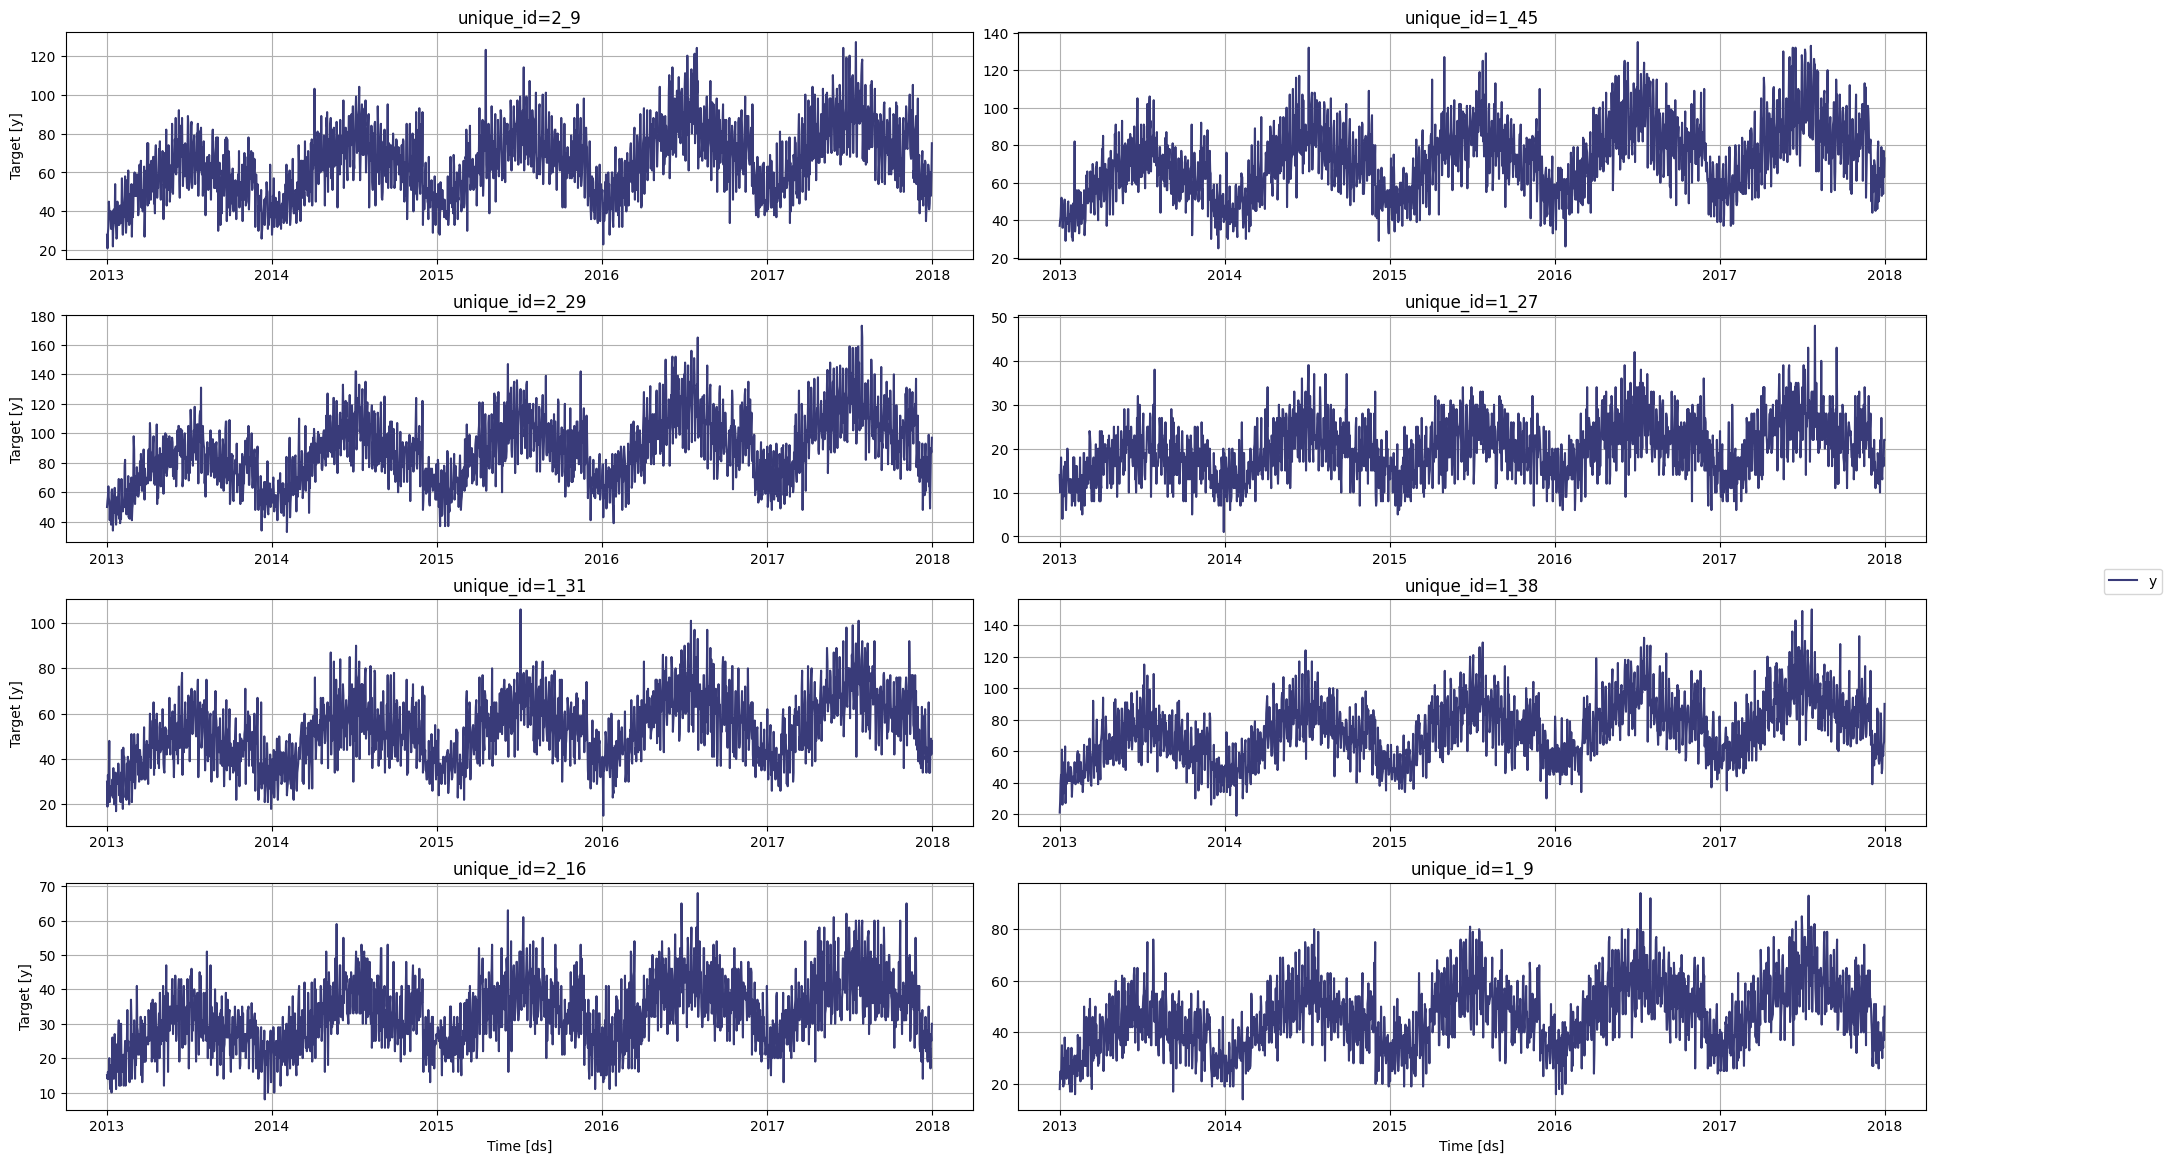

In [20]:
from tqdm.autonotebook import tqdm
from statsforecast import StatsForecast
# Plot random series for EDA
StatsForecast.plot(Y_df)

In [21]:
import darts
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality

seasonality_check_data = total_sales_per_date.reset_index()
seasonality_check_data = seasonality_check_data.set_index("date")
seasonality_check_data_series = TimeSeries.from_times_and_values(seasonality_check_data.index, seasonality_check_data["sales"].values)

plot_acf(seasonality_check_data_series, m=7, alpha=0.05, max_lag=30)

ModuleNotFoundError: No module named 'darts'